In [1]:
from os.path import join, exists
from os import makedirs
from glob import glob

import numpy as np
import pandas as pd

from tqdm import tqdm

import json

from PIL import Image, ImageFilter
from IPython.display import HTML

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm, colors, animation

from joblib import Memory

In [2]:
%matplotlib inline

---

In [3]:
import torch
from torch.distributions import Normal

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cpu'
device

'cpu'

In [4]:
dir_root = '/mnt/ext5/DRN'

dir_behav = join(dir_root, 'behav_data')
dir_reg = join(dir_behav, 'regressors/AM/value')

dir_fmri = join(dir_root,'fmri_data')
dir_mask = join(dir_fmri, 'masks')
dir_model = join(dir_root,'model')

---

In [5]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [6]:
def state_processing(obs):
    vis_obs = []

    for _obs in obs:
        ## _obs.shape = (1, 72, 128, 3)
        vis_obs.append(_obs)

    ## visual observation [(1, 72, 128, 3) x 4]
    vis_obs = np.concatenate(vis_obs, axis=-1)
    ## visual observation (1, 72, 128, 12)
    vis_obs = np.transpose(vis_obs, (0, 3, 1, 2))
    vis_obs = (vis_obs * 255).astype(np.uint8)
    
    ## visual observation (1, 12, 72, 128)
    return vis_obs

In [7]:
def convert_time_to_sec(Time):
    m, s, ds = np.array(Time.split('-')).astype(int)
    return m*60+s+0.001*ds

---

In [8]:
subj = 'DRN04'
list_run = [ss.split('/')[-1] for ss in sorted(glob(join(dir_behav,subj,'Run?')))]

---

### behavioral data

In [9]:
def get_data_behav(subj, list_run, resolution=(128,72)):
    
    dir_work = join(dir_behav,subj,'resized_%dx%d'%(resolution[0],resolution[1]))
    
    ## i) screen Shots
    dict_png = {}
    ## ii) actions
    behav = {}
    ## iii) onset times
    dict_onsettime = {}
    ## iv) onset times
    dict_action = {}
    ## v) episodes
    dict_episode = {}
    ## vi) results
    dict_result = {}
    for run in list_run:
        ## i)
        dict_png[run] = np.array(sorted(glob(join(dir_work,run,'*.png'))))
        ## ii)
        with open(join(dir_work,run,'log.json'),'r') as f:
            behav[run] = json.load(f)
#         print('%s: actions (%d) / pngs (%d)'%(run, len(behav[run]), len(dict_png[run])))

        ## iii)
        tmp = []
        ## iv)
        tmp2 = []
        ## v)
        tmp3 = []
        ## vi)
        tmp4 = []
        for dict_ in behav[run]:
            tmp.append(convert_time_to_sec(dict_['Time']))
            tmp2.append(dict_['Action'])
            tmp3.append(dict_['Episode'])
            tmp4.append(dict_['PrevEpisodeResult'])
        dict_onsettime[run] = np.array(tmp)
        dict_action[run] = np.array(tmp2)
        dict_episode[run] = np.array(tmp3)
        dict_result[run] = np.array(tmp4)
    
    return dict_png, dict_onsettime, dict_action, dict_episode, dict_result

---

the config

In [10]:
with open(join(dir_model,'drone_hanyang_mlagent.ppo/drone_hanyang_mlagent.json'),'r') as f:
    hanyang = json.load(f)
hanyang

{'env': {'name': 'drone_hanyang_mlagent', 'render': 'True', 'time_scale': 3.0},
 'agent': {'name': 'ppo',
  'network': 'continuous_policy_value',
  'head': 'cnn',
  'gamma': 0.95,
  'batch_size': 32,
  'n_step': 128,
  'n_epoch': 3,
  '_lambda': 0.95,
  'epsilon_clip': 0.1,
  'vf_coef': 1.0,
  'ent_coef': 0.01,
  'clip_grad_norm': 1.0,
  'use_standardization': 'True',
  'lr_decay': 'False'},
 'optim': {'name': 'adam', 'lr': 0.00025},
 'train': {'training': 'True',
  'load_path': './logs/drone_hanyang_mlagent/ppo/20230311094756544355/',
  'run_step': 30000000,
  'print_period': 10000,
  'save_period': 500000,
  'eval_iteration': 3,
  'record': 'False',
  'record_period': 1000000,
  'distributed_batch_size': 256,
  'update_period': "agent['n_step']",
  'num_workers': 5}}

## load pretrained parameters

In [11]:
ckpt = torch.load(
    join(dir_model,'drone_hanyang_mlagent.ppo/level2.ckpt')
    , map_location=device
)

In [12]:
for key1, dict_ in ckpt.items():
    print('################')
    print(key1)
    print('################')
    for key2, value in dict_.items():
        if type(value) is not dict:
            print('%s\n%s\n'%(key2,value.shape))
        else:
            break

################
network
################
head.conv1.weight
torch.Size([32, 12, 8, 8])

head.conv1.bias
torch.Size([32])

head.conv2.weight
torch.Size([64, 32, 4, 4])

head.conv2.bias
torch.Size([64])

head.conv3.weight
torch.Size([64, 64, 3, 3])

head.conv3.bias
torch.Size([64])

l.weight
torch.Size([512, 3840])

l.bias
torch.Size([512])

mu.weight
torch.Size([3, 512])

mu.bias
torch.Size([3])

log_std.weight
torch.Size([3, 512])

log_std.bias
torch.Size([3])

v.weight
torch.Size([1, 512])

v.bias
torch.Size([1])

################
optimizer
################


---

In [13]:
def get_idx_input(subj, list_run, run, shift=0):
    nFrameStack = 4
    TR = 0.5
    
    _, dict_onsettime, _, _, _ = get_data_behav(subj,list_run)

    onsettimes = dict_onsettime[run]
    onsettimes = onsettimes[onsettimes<700-shift]

    ## A set of the last indices for each episode except the last episode
    idx_final = np.concatenate([np.where(np.diff(onsettimes)>TR)[0], [onsettimes.shape[0]-1]])
    idx_initial = np.concatenate([[0],idx_final[:-1]+1])
    assert idx_initial.shape == idx_final.shape

    idx_input = {}
    idx_epi = {}
    for ii, (idx_i, idx_f) in enumerate(zip(idx_initial, idx_final)):
        episode = 'episode:%02d'%(ii+1)

        ## the times of the initial and final frame
        ta, tb = onsettimes[idx_i], onsettimes[idx_f]
        ## the number of frames at the episode
        n_frame = int(idx_f-idx_i+1)

        ## The fMRI image corresponding to the first frame of this episode
        a = ta - ta%TR
        ## The fMRI image corresponding to the final frame of this episode
        b = tb - tb%TR

        ## The number of fMRI images representing the corresponding episode.
        n_epi = int((b-a)/TR + 1)
        if n_epi <= 1:
            continue

        ## The fMRI indices that make up each episode
        timepoint_epi = np.arange(a,b+TR,TR)+shift
        timepoint_epi = timepoint_epi[timepoint_epi<700]
        idx_epi[episode] = (2*(timepoint_epi-6)).astype(int)

        ## an input set to forward via a model
        idx_input[episode] = np.zeros((n_epi,nFrameStack)).astype(int)

        ## the last input
        idx_input[episode][-1] = [idx_f-nFrameStack+1+jj for jj in range(nFrameStack)]

        ## the rest of them
        didx = (idx_f-nFrameStack-idx_i)*TR/(b-a+1.e-8)
        for jj in range(n_epi-1):
            idx_input[episode][jj] = [int(idx_i+didx*jj+kk) for kk in range(nFrameStack)]

    for episode, input_ in idx_input.items():
        assert input_.shape[0] == idx_epi[episode].shape[0]
    
    return idx_input, idx_epi

---

# Encoding model

#### Network

In [14]:
from core.network import *

InputShape = (12,72,128)
network = policy_value.ContinuousPolicyValue(D_in=InputShape, D_out=3, D_hidden=512, head='cnn')
network.eval().to(device)

ContinuousPolicyValue(
  (head): CNN(
    (conv1): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (l): Linear(in_features=3840, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=3, bias=True)
  (log_std): Linear(in_features=512, out_features=3, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=True)
)

In [15]:
# for layer in [network.head.conv1, network.head.conv2, network.head.conv3]:
#     for kernel in layer.weight.detach().numpy():
#         print('mean=%.5e\tstd=%.5e'%(kernel.mean(),kernel.std()))
#     print('\n')

In [16]:
input_ = torch.rand((5,*InputShape))
print(input_.shape)
(mu, std, v), (conv1, conv2, conv3) = network(input_.to(device))

conv1.shape, conv2.shape, conv3.shape, mu.shape, std.shape, v.shape

torch.Size([5, 12, 72, 128])


(torch.Size([5, 32, 17, 31]),
 torch.Size([5, 64, 7, 14]),
 torch.Size([5, 64, 5, 12]),
 torch.Size([5, 3]),
 torch.Size([5, 3]),
 torch.Size([5, 1]))

#### copy parameters `network.head.weight = torch.nn.Parameter(ckpt['network'].head)`

In [17]:
network.load_state_dict(ckpt['network'])

<All keys matched successfully>

In [18]:
kernel = network.head.conv1.weight.detach().numpy()
kernel.shape

(32, 12, 8, 8)

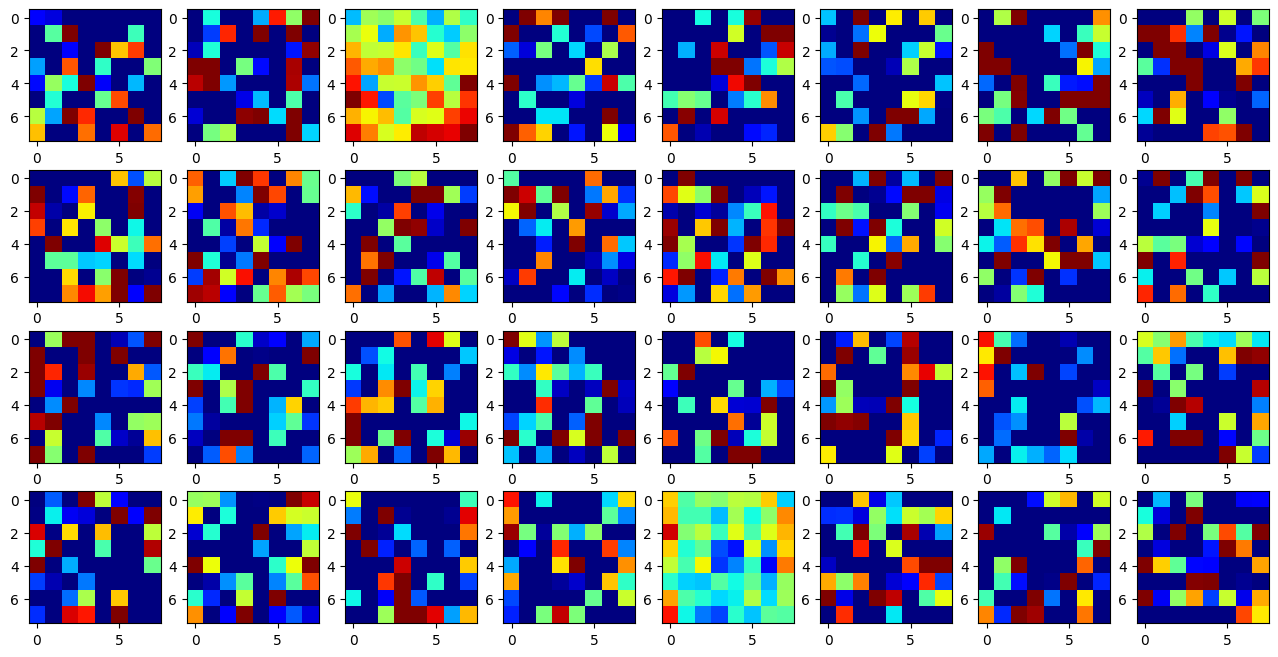

In [20]:
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=np.array([8,4])*2)
axs = np.concatenate(axs)

for ii, k in enumerate(kernel):
    ax = axs[ii]
    img = k.mean(axis=0)
#     img = k[1]
    ax.imshow(
        img,
        cmap='jet',
        vmin=-0.01, vmax=0.01
    )

---

In [18]:
dir_cache = join(dir_root,'cache/forward')
makedirs(dir_cache, exist_ok=True)

memory = Memory(dir_cache, verbose=0)

@memory.cache
def do_forward(subj, list_run, run, shift=0):
    ## ======================= setup ======================= ##
    dict_png, _, _, _, _ = get_data_behav(subj, list_run)
    idx_input, idx_epi = get_idx_input(subj, list_run, run, shift=shift)

    for ii, (episode, indices) in enumerate(idx_epi.items()):
        ## 해당 EPI index에 매칭되는 png의 index들
        tmp = idx_input[episode]

        ## 해당 RUN에 input으로 쓰일 모든 png fname 들
        if ii > 0:
            input_fname = np.concatenate(
                [
                    input_fname,
                    dict_png[run][tmp]
                ],
                axis=0
            )
        else:
            input_fname = dict_png[run][tmp]

    ## (batch size of Run, 4)
    (batch, _) = input_fname.shape

    ## ======================= input ======================= ##
    ## Actual input values to be entered into the network
    input_ = np.zeros((batch,12,72,128), dtype=np.uint8)

    for timepoint, fnames in enumerate(tqdm(input_fname)):
        ## 4 frames (1,72,128,3) 를 numpy 로 불러와서 쌓음
        tmp = np.stack(
            [np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in fnames],
            axis=0
        )

        ## 이미지 전처리 (4, 1, 72, 128, 3) -> (12, 72, 128, 3)
        input_[timepoint] = state_processing(tmp)

    del tmp
    ## 이미지를 torch.tensor 로 변경
    input_ = torch.from_numpy(input_)
    ## ========================== Forward ========================== ##
    ## 쌓은 frame 들을 network에 입력
    with torch.no_grad():
        output_ = network(input_.to(device))

    return input_, output_

---

In [19]:
dict_png, dict_onsettime, dict_action, dict_episode, dict_result = get_data_behav(subj=subj, list_run=list_run)

---

Value function

Run1
x r=-0.093 p=0.001(***)
y r=0.003 p=0.907(ns)
z r=0.102 p=0.000(***)
Run2
x r=-0.120 p=0.000(****)
y r=0.009 p=0.735(ns)
z r=0.068 p=0.014(*)
Run3
x r=-0.139 p=0.000(****)
y r=-0.024 p=0.392(ns)
z r=0.200 p=0.000(****)
Run4
x r=-0.117 p=0.000(****)
y r=0.027 p=0.327(ns)
z r=0.097 p=0.001(***)
Run5
x r=-0.149 p=0.000(****)
y r=0.037 p=0.182(ns)
z r=0.095 p=0.001(***)
Run6
x r=-0.118 p=0.000(****)
y r=-0.061 p=0.031(*)
z r=0.141 p=0.000(****)


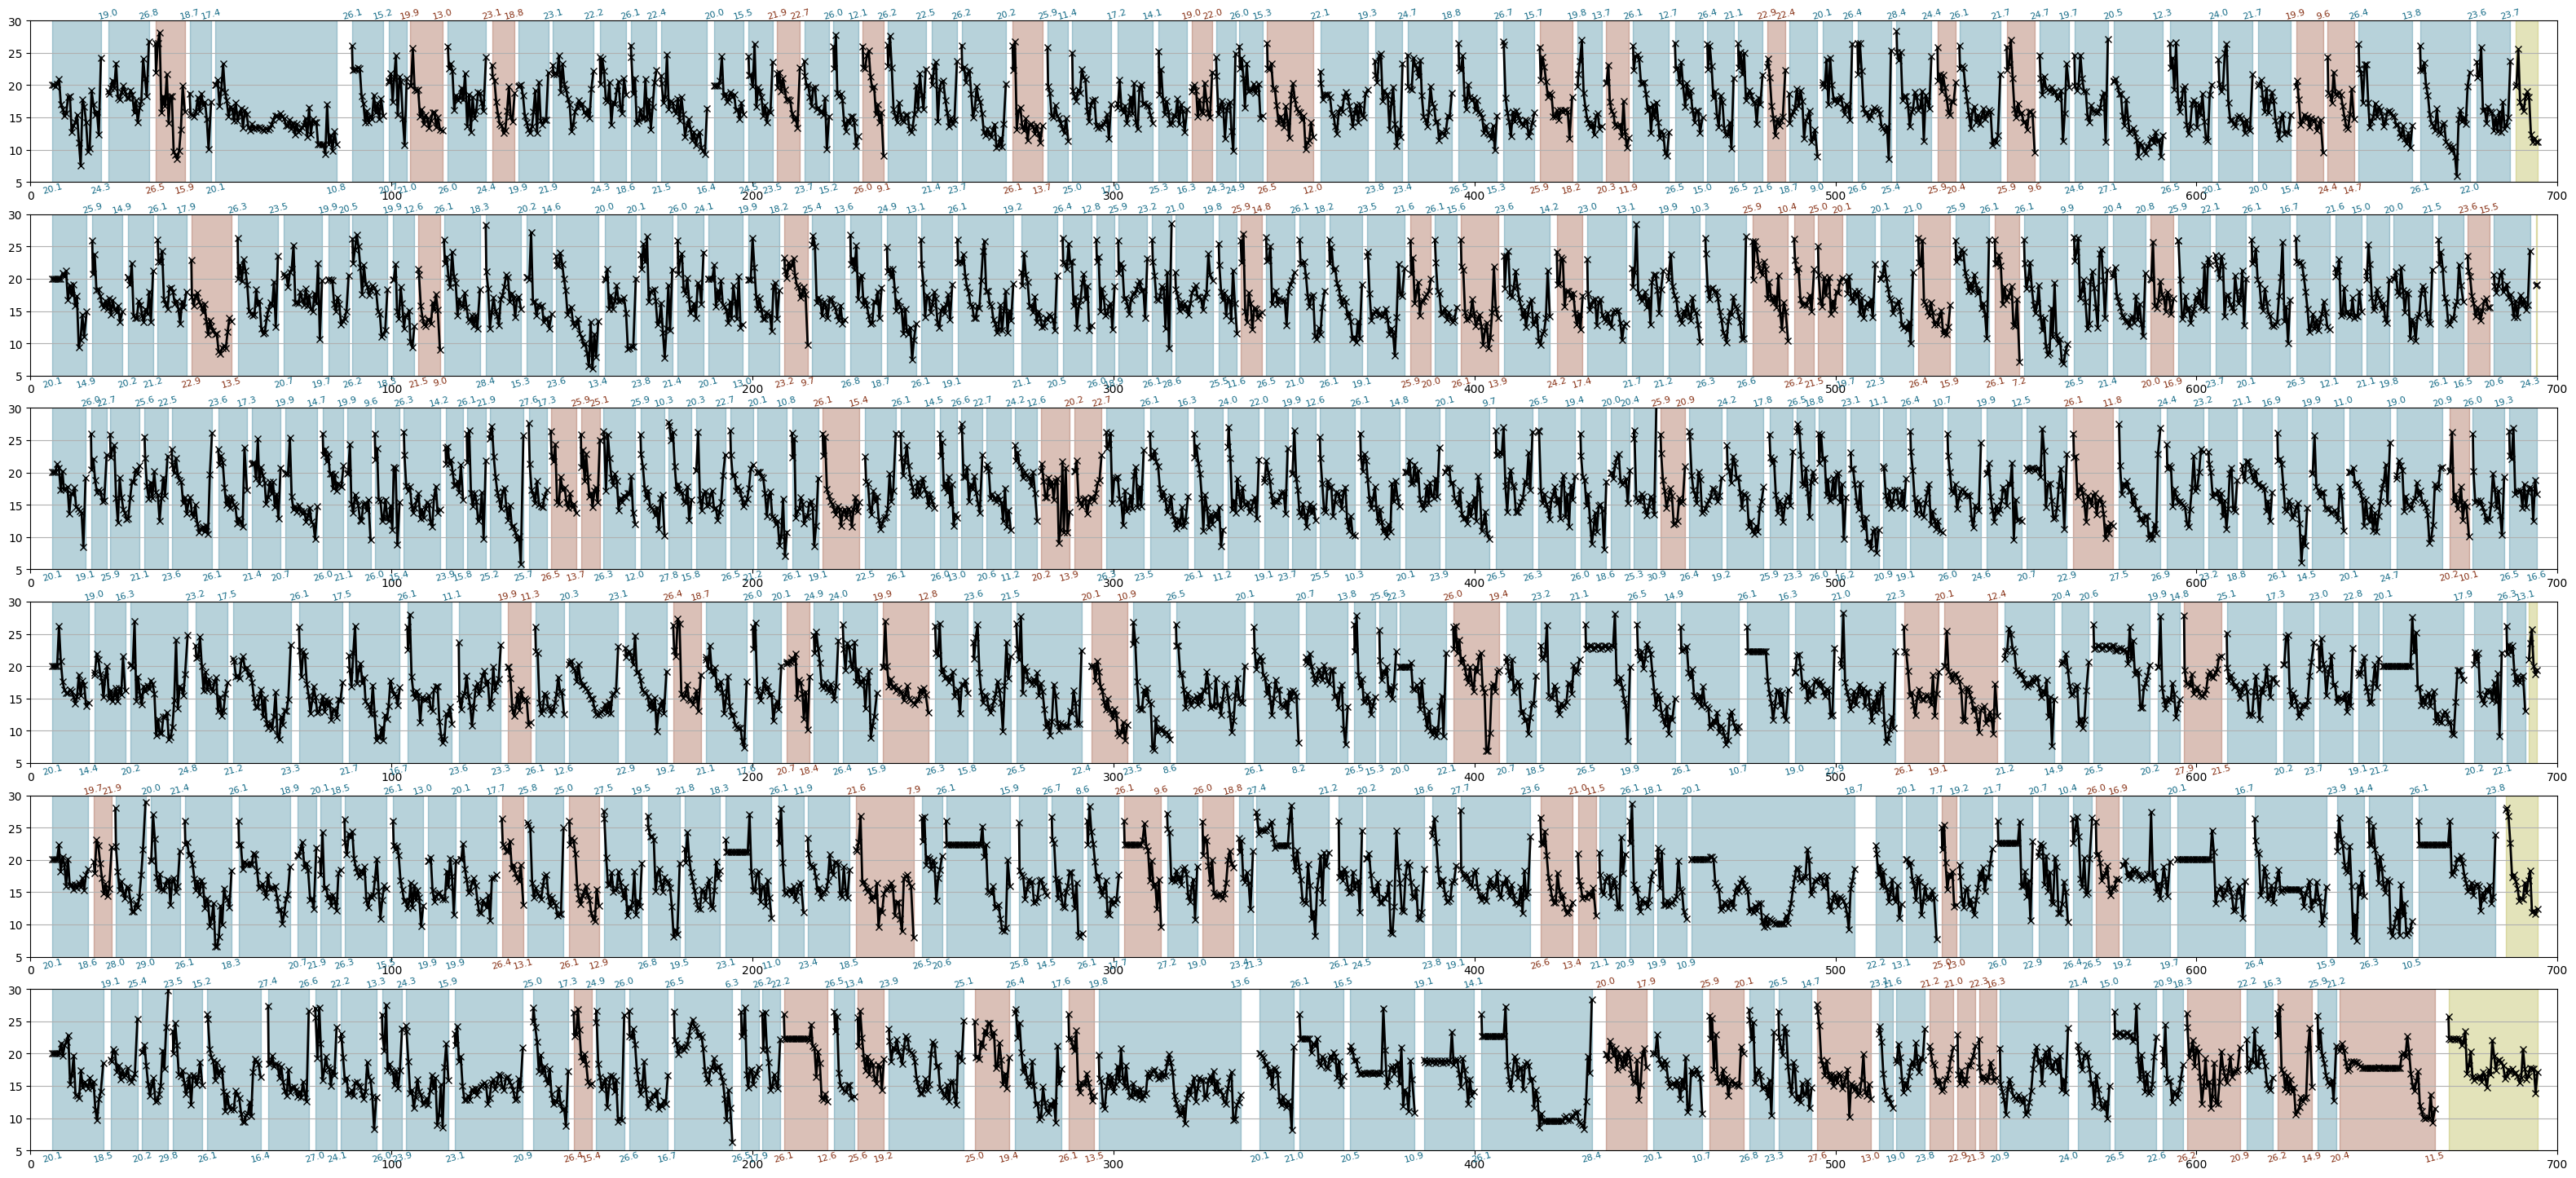

In [28]:
nrows=len(list_run)
fig, axs = plt.subplots(nrows=nrows, figsize=(40,nrows*3))

for rr, (run, onset) in enumerate(dict_onsettime.items()):
    
    ## ======================================================= ##

    ## forward
    input_, output_ = do_forward(subj, list_run, run, shift=5)
    ninput = input_.shape[0]
    (mu, std, val), _ = output_
    
    ## ======================================================= ##
    
    ## the first index of each input (Reduced data list)
    idx_input, idx_epi = get_idx_input(subj=subj, run=run, list_run=list_run, shift=0)
    for ii, (k, v) in enumerate(idx_input.items()):
        if ii > 0:
            idx_FirstShot = np.concatenate([idx_FirstShot, v[:,0]])
        else:
            idx_FirstShot = v[:,0]
    idx_FirstShot = idx_FirstShot[:ninput]
    
    ## onsettimes (Reduced data list)
    list_onsettime = dict_onsettime[run][idx_FirstShot]

    ## episode (Reduced data list)
    list_episode = dict_episode[run][idx_FirstShot][:ninput]
    
    ## success/failure (size = # of episodes)
    list_idx_terminal = np.where(np.diff(dict_episode[run]))[0]
    list_result = np.concatenate(
        [dict_result[run][list_idx_terminal+1], ['Yet']],
        axis=None
    )
    
    ## ======================================================= ##

    ## Action (Reduced data list)
    z = torch.normal(mu, std)
    action_pred = torch.tanh(z).numpy()
    
    action_real = dict_action[run][idx_FirstShot]
    
    ## value function (Reduced data list)
    list_value = np.squeeze(val.numpy())

    print(run)
    for ii, xx in enumerate(['x','y','z']):
        a = action_real[:,ii]
        b = action_pred[:,ii]
        r, p = stats.pearsonr(a,b)
        print(xx, 'r=%.3f'%r, 'p=%.3f(%s)'%(p,convert_pvalue_to_asterisks(p)))
    
    ## ======================================================= ##
    
    ## plot
    ax = axs[rr]
    for ii, episode in enumerate(np.unique(list_episode)):
        list_idx = np.where(list_episode==episode)[0]
        x = list_onsettime[list_idx]
        y = list_value[list_idx]
        ax.plot(
            x, y,
            marker='x',  markersize=6,
            linestyle='-', linewidth=2,
            color='black',
        )
        ## result
        res = list_result[ii]
        color = '#136A86' if res=='Success' else ('#862F13' if res=='Collided' else '#A4A31C')
        ax.fill_between(
            x=x,
            y1=0, y2=35,
            where=np.ones(x.shape),
            color=color, alpha=0.3
        )
        if res == 'Yet':
            continue
        
        if episode%2==0:
            h=5
            v='top'
        else:
            h=30
            v='bottom'
        ## the initial value function
        ax.text(
            x=x[0],
            y=h,
            s='%.1f'%y[0],
            fontdict={
                'fontsize':8,
                'color':color,
                'horizontalalignment':'center',
                'verticalalignment':v,
                'rotation':15
            }
        )
        ## the final value function
        ax.text(
            x=x[-1],
            y=h,
            s='%.1f'%y[-1],
            fontdict={
                'fontsize':8,
                'color':color,
                'horizontalalignment':'center',
                'verticalalignment':v,
                'rotation':15
            }
        )
        
    ylim = ax.get_ylim()
    ylim = (5,30)
    ax.set_xlim([0,700])
    ax.grid(axis='y')
    ax.set_ylim(ylim)

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/DRN/results/value_function.png',
#     dpi=300, facecolor=[1,1,1,0],
#     bbox_inches='tight'
# )

---

In [29]:
run = 'Run1'
shift = 5

In [30]:
input_, output_ = do_forward(subj, list_run, run, shift=shift)

(mu, std, val), (conv1, conv2, conv3) = output_

In [31]:
idx_input, idx_epi = get_idx_input(subj, list_run, run, shift=shift)

for episode, tmp in idx_input.items():
    if episode=='episode:01':
        list_idx = tmp
    else:
        list_idx = np.concatenate((list_idx, tmp), axis=0)

---

Make a GIF

In [32]:
# fig = plt.figure(figsize=np.array([12.8,7.2])*0.3)
# plt.axis('off')

# img = []
# for idx in range(10,140):
#     img.append(
#         [plt.imshow(Image.open(dict_png[run][idx]), animated=True)]
#     )

# ani = animation.ArtistAnimation(fig, img, interval=100)
# ani.save('/home/sungbeenpark/Github/labs/DRN/results/%s.gif'%subj, writer='imagemagick')

# HTML(ani.to_jshtml())

---

In [56]:
idx = 500

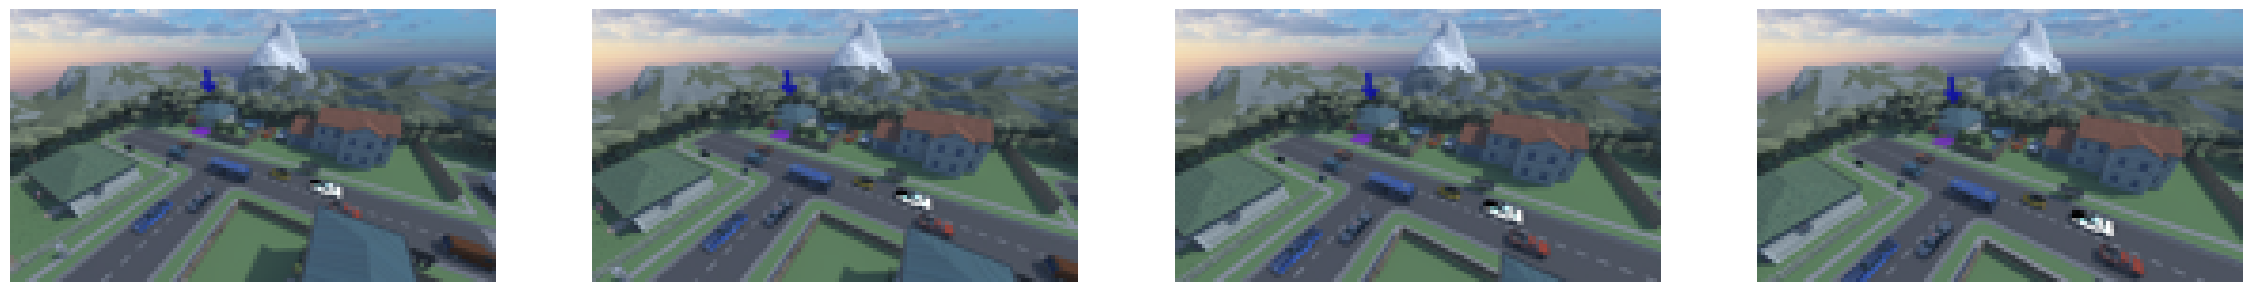

In [57]:
fig, axs = plt.subplots(ncols=4, figsize=(7.2*4, 12.8))

for ii, fname in enumerate(dict_png[run][list_idx[idx]]):
    ax = axs[ii]
    img = Image.open(fname)
    ax.imshow(img)
    ax.axis('off')

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/DRN/results/input_0.png',
#     dpi=300, facecolor=[1,1,1,0],
#     bbox_inches='tight'
# )

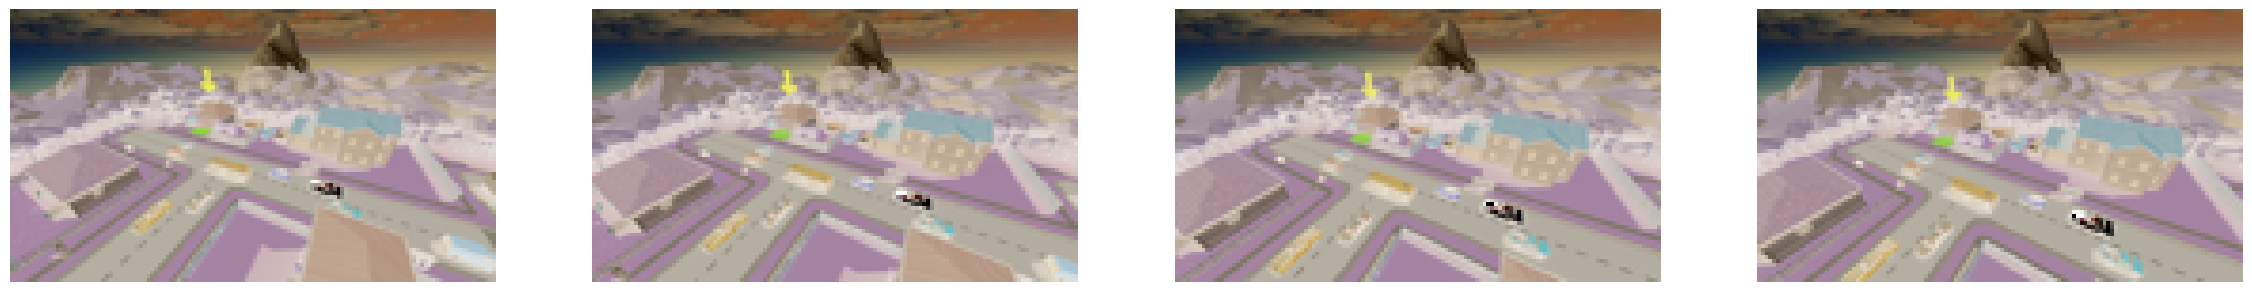

In [58]:
## input
fig, axs = plt.subplots(ncols=4, figsize=(7.2*4, 12.8))
for ii in range(4):
    ax = axs[ii]
    img = input_[idx][ii*3:(ii+1)*3]
    ax.imshow(np.transpose(img,(1,2,0)))
    ax.set_axis_off()
    
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/DRN/results/input_1.png',
#     dpi=300, facecolor=[1,1,1,0],
#     bbox_inches='tight'
# )

31x17x32
14x7x64
12x5x64
16.544525


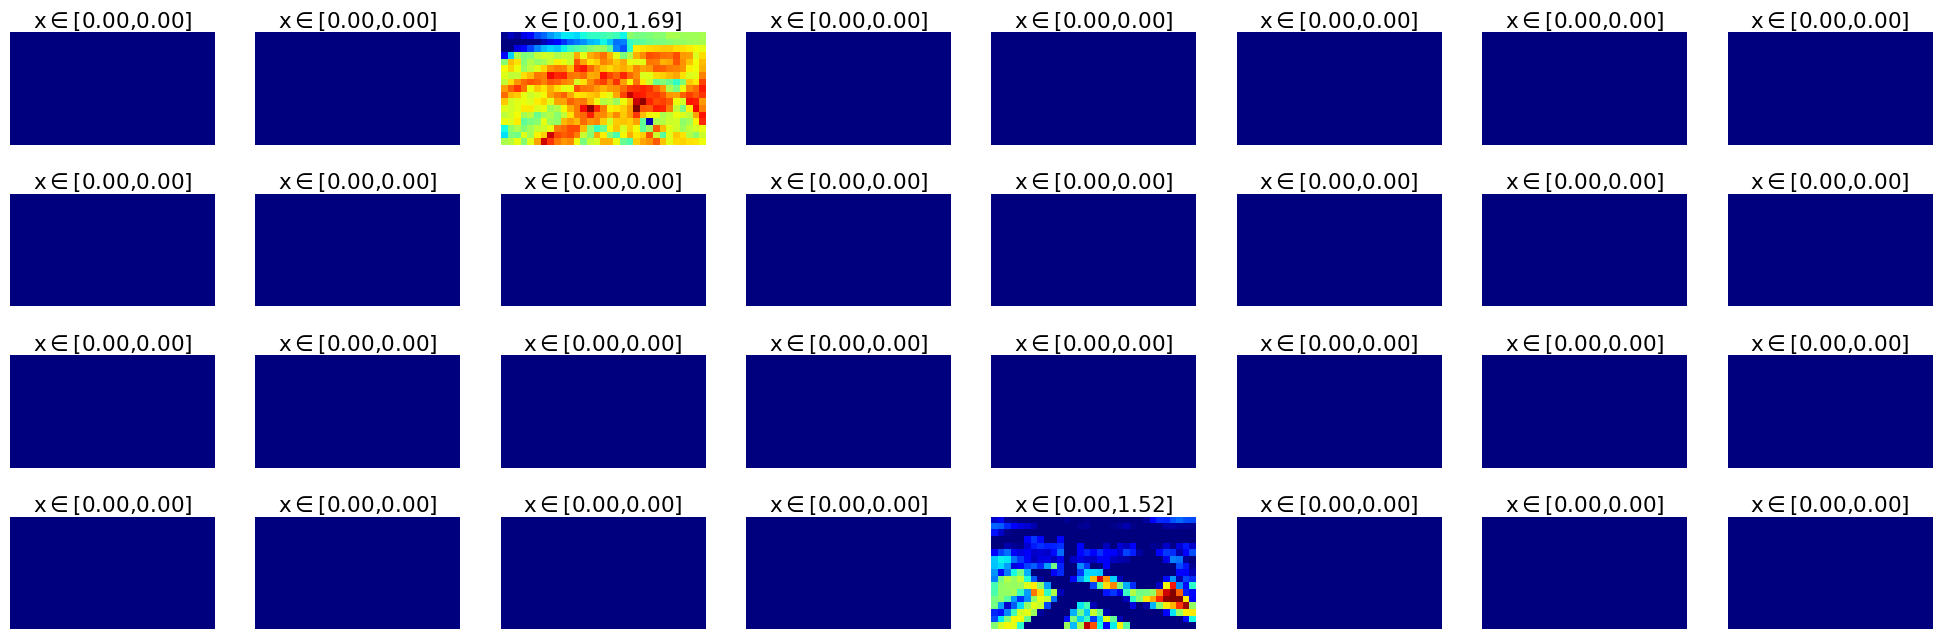

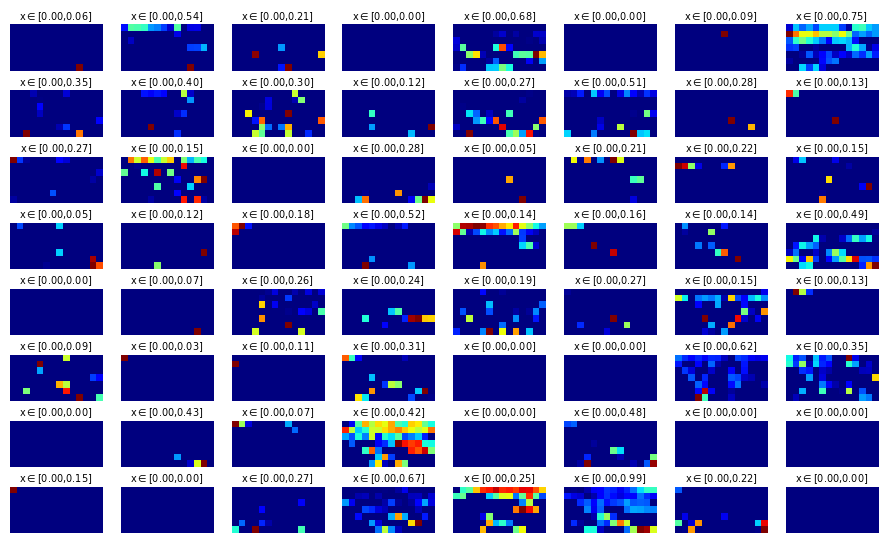

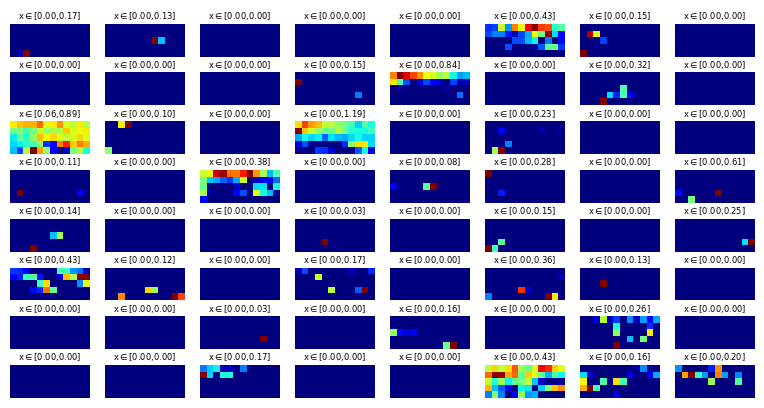

In [65]:
## output
for ii, cc in enumerate([conv1, conv2, conv3]):
    nfilters, height, width = cc.shape[1:]
    print('%dx%dx%d'%(width,height,nfilters))
    
    ncols = 8
    nrows = nfilters // ncols
    
    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows,
        figsize=(ncols*width*0.1, nrows*(height+width*0.1)*0.1)
    )
    axs = np.concatenate(axs)
    for jj, ax in enumerate(axs):
        img = cc[idx,jj].numpy()
        ax.imshow(
            img, cmap='jet',
#             vmin=0, vmax=5
        )
        ax.set_title(
            r'x$\in$[%.2f,%.2f]'%(float(img.min()),float(img.max())),
            fontdict={
                'fontsize':width*0.5,
                'horizontalalignment':'center',
                'verticalalignment':'center'
            }
        )
        ax.set_axis_off()
#     fig.savefig(
#         '/home/sungbeenpark/Github/labs/DRN/results/conv%d.png'%(ii+1),
#         dpi=300, facecolor=[1,1,1,0],
#         bbox_inches='tight'
#     )
    
print(val.numpy()[idx][0])

---